# Programming Exercise 2: Logistic Regression

## Introduction

In this exercise, you will implement logistic regression and apply it to two different datasets. 

In [0]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 1 Logistic Regression

In this part of the exercise, you will build a logistic regression model to predict whether a student gets admitted into a university. Suppose that you are the administrator of a university department and
you want to determine each applicant’s chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant’s scores on two exams and the admissions
decision. Your task is to build a classification model that estimates an applicant’s probability of admission based the scores from those two exams. 

The following cell will load the data and corresponding labels:

In [0]:
# Load data
# The first two columns contains the exam scores and the third column
# contains the label.
data = np.loadtxt(os.path.join('Data', '/content/ex2data1.txt'), delimiter=',')
X, y = data[:, 0:2], data[:, 2]

### 1.1 Visualizing the data

Before starting to implement any learning algorithm, it is always good to visualize the data if possible. We  display the data on a 2-dimensional plot by calling the function `plotData`. You will now complete the code in `plotData` so that it displays a figure where the axes are the two exam scores, and the positive and negative examples are shown with different markers.

To help you get more familiar with plotting, we have left `plotData` empty so you can try to implement it yourself. We also provide our implementation below so you can
copy it or refer to it. If you choose to copy our example, make sure you learn
what each of its commands is doing by consulting the `matplotlib` and `numpy` documentation.

```python
# Find Indices of Positive and Negative Examples
pos = y == 1
neg = y == 0

# Plot Examples
pyplot.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10)
pyplot.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)
```

In [0]:
def plotData(X, y):
    """
    Plots the data points X and y into a new figure. Plots the data 
    points with * for the positive examples and o for the negative examples.
    
    Parameters
    ----------
    X : array_like
        An Mx2 matrix representing the dataset. 
    
    y : array_like
        Label values for the dataset. A vector of size (M, ).
    
    Instructions
    ------------
    Plot the positive and negative examples on a 2D plot, using the
    option 'k*' for the positive examples and 'ko' for the negative examples.    
    """
    # Create New Figure
    fig = pyplot.figure()

    # ====================== YOUR CODE HERE ======================
    # Find Indices of Positive and Negative Examples
    positive = y == 1
    negative = y == 0
    pyplot.plot(X[positive, 0], X[positive, 1], 'k*', lw=2, ms=10)
    pyplot.plot(X[negative, 0], X[negative, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)
    
    # ============================================================

Now, we call the implemented function to display the loaded data:

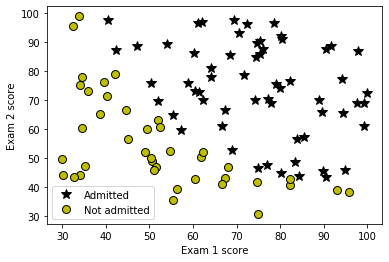

In [6]:
plotData(X, y)
# add axes labels
pyplot.xlabel('Exam 1 score')
pyplot.ylabel('Exam 2 score')
pyplot.legend(['Admitted', 'Not admitted'])
pass

<a id="section1"></a>
### 1.2 Implementation

#### 1.2.1 Warmup exercise: sigmoid function

Before you start with the actual cost function, recall that the logistic regression hypothesis is defined as:

$$ h_\theta(x) = g(\theta^T x)$$

where function $g$ is the sigmoid function. The sigmoid function is defined as: 

$$g(z) = \frac{1}{1+e^{-z}}$$.

Your first step is to implement this function `sigmoid` so it can be
called by the rest of your program. When you are finished, try testing a few
values by calling `sigmoid(x)` in a new cell. For large positive values of `x`, the sigmoid should be close to 1, while for large negative values, the sigmoid should be close to 0. Evaluating `sigmoid(0)` should give you exactly 0.5. Your code should also work with vectors and matrices. **For a matrix, your function should perform the sigmoid function on every element.**
<a id="sigmoid"></a>

In [0]:
def sigmoid(z):
    """
    Compute sigmoid function given the input z.
    
    Parameters
    ----------
    z : array_like
        The input to the sigmoid function. This can be a 1-D vector 
        or a 2-D matrix. 
    
    Returns
    -------
    g : array_like
        The computed sigmoid function. g has the same shape as z, since
        the sigmoid is computed element-wise on z.
        
    Instructions
    ------------
    Compute the sigmoid of each value of z (z can be a matrix, vector or scalar).
    """
    # convert input to a numpy array
    z = np.array(z)
    
    # You need to return the following variables correctly 
    g = np.zeros(z.shape)

    # ====================== YOUR CODE HERE ======================
    g = (1 / (1 + np.exp(-z)) )

    # =============================================================
    return g

The following cell evaluates the sigmoid function at `z=0`. You should get a value of 0.5. You can also try different values for `z` to experiment with the sigmoid function.

In [8]:
# Test the implementation of sigmoid function here
z = 0
g = sigmoid(z)

print('g(', z, ') = ', g)

g( 0 ) =  0.5


After completing a part of the exercise, you can submit your solutions for grading by first adding the function you modified to the submission object, and then sending your function to Coursera for grading. 

The submission script will prompt you for your login e-mail and submission token. You can obtain a submission token from the web page for the assignment. You are allowed to submit your solutions multiple times, and we will take only the highest score into consideration.





<a id="section2"></a>
#### 1.2.2 Cost function and gradient

Now you will implement the cost function and gradient for logistic regression. Before proceeding we add the intercept term to X. 

In [0]:
# Setup the data matrix appropriately, and add ones for the intercept term
m, n = X.shape

# Add intercept term to X
X = np.concatenate([np.ones((m, 1)), X], axis=1)

Now, complete the code for the function `costFunction` to return the cost and gradient. Recall that the cost function in logistic regression is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

and the gradient of the cost is a vector of the same length as $\theta$ where the $j^{th}$
element (for $j = 0, 1, \cdots , n$) is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Note that while this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $h_\theta(x)$.
<a id="costFunction"></a>

In [0]:
def costFunction(theta, X, y):
    """
    Compute cost and gradient for logistic regression. 
    
    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).
    
    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the 
        intercept has already been added to the input.
    
    y : arra_like
        Labels for the input. This is a vector of shape (m, ).
    
    Returns
    -------
    J : float
        The computed value for the cost function. 
    
    grad : array_like
        A vector of shape (n+1, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
        
    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to 
    the cost. Compute the partial derivatives and set grad to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    # Initialize some useful values
    m = y.size  # number of training examples

    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    # ====================== YOUR CODE HERE ======================
    for i in range(m):
        dot = np.dot(X[i,:],theta)
        H   = sigmoid(dot)
        J = J + ( (-1 * y[i] * np.log(H) ) - ((1-y[i]) * np.log(1-H)) )
    J = J / m  
    
    H = sigmoid(np.dot(X,theta))
    sum = np.dot(X.T,H-y)
    grad = sum / m  
    # =============================================================
    return J, grad

Once you are done call your `costFunction` using two test cases for  $\theta$ by executing the next cell.

In [11]:
# Initialize fitting parameters
initial_theta = np.zeros(n+1)

cost, grad = costFunction(initial_theta, X, y)

print('Cost at initial theta (zeros): {:.3f}'.format(cost))
print('Expected cost (approx): 0.693\n')

print('Gradient at initial theta (zeros):')
print('\t[{:.4f}, {:.4f}, {:.4f}]'.format(*grad))
print('Expected gradients (approx):\n\t[-0.1000, -12.0092, -11.2628]\n')

# Compute and display cost and gradient with non-zero theta
test_theta = np.array([-24, 0.2, 0.2])
cost, grad = costFunction(test_theta, X, y)

print('Cost at test theta: {:.3f}'.format(cost))
print('Expected cost (approx): 0.218\n')

print('Gradient at test theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*grad))
print('Expected gradients (approx):\n\t[0.043, 2.566, 2.647]')

Cost at initial theta (zeros): 0.693
Expected cost (approx): 0.693

Gradient at initial theta (zeros):
	[-0.1000, -12.0092, -11.2628]
Expected gradients (approx):
	[-0.1000, -12.0092, -11.2628]

Cost at test theta: 0.218
Expected cost (approx): 0.218

Gradient at test theta:
	[0.043, 2.566, 2.647]
Expected gradients (approx):
	[0.043, 2.566, 2.647]


#### 1.2.3 Learning parameters using `scipy.optimize`

In the previous assignment, you found the optimal parameters of a linear regression model by implementing gradient descent. You wrote a cost function and calculated its gradient, then took a gradient descent step accordingly. This time, instead of taking gradient descent steps, you will use the [`scipy.optimize` module](https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy is a numerical computing library for `python`. It provides an optimization module for root finding and minimization. As of `scipy 1.0`, the function `scipy.optimize.minimize` is the method to use for optimization problems(both constrained and unconstrained).

For logistic regression, you want to optimize the cost function $J(\theta)$ with parameters $\theta$.
Concretely, you are going to use `optimize.minimize` to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (of X and y values). You will pass to `optimize.minimize` the following inputs:
- `costFunction`: A cost function that, when given the training set and a particular $\theta$, computes the logistic regression cost and gradient with respect to $\theta$ for the dataset (X, y). It is important to note that we only pass the name of the function without the parenthesis. This indicates that we are only providing a reference to this function, and not evaluating the result from this function.
- `initial_theta`: The initial values of the parameters we are trying to optimize.
- `(X, y)`: These are additional arguments to the cost function.
- `jac`: Indication if the cost function returns the Jacobian (gradient) along with cost value. (True)
- `method`: Optimization method/algorithm to use
- `options`: Additional options which might be specific to the specific optimization method. In the following, we only tell the algorithm the maximum number of iterations before it terminates.

If you have completed the `costFunction` correctly, `optimize.minimize` will converge on the right optimization parameters and return the final values of the cost and $\theta$ in a class object. Notice that by using `optimize.minimize`, you did not have to write any loops yourself, or set a learning rate like you did for gradient descent. This is all done by `optimize.minimize`: you only needed to provide a function calculating the cost and the gradient.

In the following, we already have code written to call `optimize.minimize` with the correct arguments.

In [12]:
# set options for optimize.minimize
options= {'maxiter': 400}

# see documention for scipy's optimize.minimize  for description about
# the different parameters
# The function returns an object `OptimizeResult`
# We use truncated Newton algorithm for optimization which is 
# equivalent to MATLAB's fminunc
# See https://stackoverflow.com/questions/18801002/fminunc-alternate-in-numpy
res = optimize.minimize(costFunction,
                        initial_theta,
                        (X, y),
                        jac=True,
                        method='TNC',
                        options=options)

# the fun property of `OptimizeResult` object returns
# the value of costFunction at optimized theta
cost = res.fun

# the optimized theta is in the x property
theta = res.x

# Print theta to screen
print('Cost at theta found by optimize.minimize: {:.3f}'.format(cost))
print('Expected cost (approx): 0.203\n');

print('theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*theta))
print('Expected theta (approx):\n\t[-25.161, 0.206, 0.201]')

Cost at theta found by optimize.minimize: 0.203
Expected cost (approx): 0.203

theta:
	[-25.161, 0.206, 0.201]
Expected theta (approx):
	[-25.161, 0.206, 0.201]


Once `optimize.minimize` completes, we want to use the final value for $\theta$ to visualize the decision boundary on the training data as shown in the figure below. 

![](Figures/decision_boundary1.png)

To do so, we have written a function plotDecisionBoundary for plotting the decision boundary on top of training data. You do not need to write any code for plotting the decision boundary, but we also encourage you to look at the code in plotDecisionBoundary to see how to plot such a boundary using the  𝜃  values. You can find this function in the utils.py file which comes with this assignment.


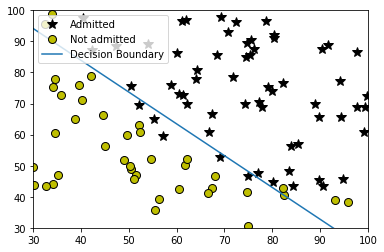

In [13]:
# Plot Boundary
utils.plotDecisionBoundary(plotData, theta, X, y)

<a id="section4"></a>
#### 1.2.4 Evaluating logistic regression

After learning the parameters, you can use the model to predict whether a particular student will be admitted. For a student with an Exam 1 score of 45 and an Exam 2 score of 85, you should expect to see an admission
probability of 0.776. Another way to evaluate the quality of the parameters we have found is to see how well the learned model predicts on our training set. In this part, your task is to complete the code in function `predict`. The predict function will produce “1” or “0” predictions given a dataset and a learned parameter vector $\theta$. 
<a id="predict"></a>

In [0]:
def predict(theta, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression.
    Computes the predictions for X using a threshold at 0.5 
    (i.e., if sigmoid(theta.T*x) >= 0.5, predict 1)
    
    Parameters
    ----------
    theta : array_like
        Parameters for logistic regression. A vecotor of shape (n+1, ).
    
    X : array_like
        The data to use for computing predictions. The rows is the number 
        of points to compute predictions, and columns is the number of
        features.

    Returns
    -------
    p : array_like
        Predictions and 0 or 1 for each row in X. 
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned 
    logistic regression parameters.You should set p to a vector of 0's and 1's    
    """
    m = X.shape[0] # Number of training examples

    # You need to return the following variables correctly
    p = np.zeros(m)

    # ====================== YOUR CODE HERE ======================
    for i in range(m):
        value = sigmoid(np.dot(theta,X[i]))
        if value >= 0.5 :
            p[i] = 1
        else:
            p[i] = 0   
    # ============================================================
    return p

After you have completed the code in `predict`, we proceed to report the training accuracy of your classifier by computing the percentage of examples it got correct.

In [15]:
#  Predict probability for a student with score 45 on exam 1 
#  and score 85 on exam 2 
prob = sigmoid(np.dot([1, 45, 85], theta))
print('For a student with scores 45 and 85,'
      'we predict an admission probability of {:.3f}'.format(prob))
print('Expected value: 0.775 +/- 0.002\n')

# Compute accuracy on our training set
p = predict(theta, X)
print('Train Accuracy: {:.2f} %'.format(np.mean(p == y) * 100))
print('Expected accuracy (approx): 89.00 %')

For a student with scores 45 and 85,we predict an admission probability of 0.776
Expected value: 0.775 +/- 0.002

Train Accuracy: 89.00 %
Expected accuracy (approx): 89.00 %


## 2 Regularized logistic regression

In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.
Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

First, we load the data from a CSV file:

In [0]:
# Load Data
# The first two columns contains the X values and the third column
# contains the label (y).
data = np.loadtxt(os.path.join('Data', '/content/ex2data2.txt'), delimiter=',')
X = data[:, :2]
y = data[:, 2]

### 2.1 Visualize the data

Similar to the previous parts of this exercise, `plotData` is used to generate a figure, where the axes are the two test scores, and the positive (y = 1, accepted) and negative (y = 0, rejected) examples are shown with
different markers.

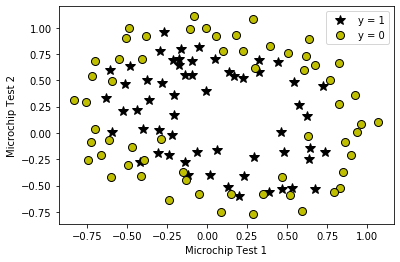

In [19]:
plotData(X, y)
# Labels and Legend
pyplot.xlabel('Microchip Test 1')
pyplot.ylabel('Microchip Test 2')

# Specified in plot order
pyplot.legend(['y = 1', 'y = 0'], loc='upper right')
pass

The above figure shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight-forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

### 2.2 Feature mapping

One way to fit the data better is to create more features from each data point. In the function `mapFeature` defined in the file `utils.py`, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$ \text{mapFeature}(x) = \begin{bmatrix} 1 & x_1 & x_2 & x_1^2 & x_1 x_2 & x_2^2 & x_1^3 & \dots & x_1 x_2^5 & x_2^6 \end{bmatrix}^T $$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.
While the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting. In the next parts of the exercise, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.


In [0]:
# Note that mapFeature also adds a column of ones for us, so the intercept
# term is handled
X = utils.mapFeature(X[:, 0], X[:, 1])

<a id="section5"></a>
### 2.3 Cost function and gradient

Now you will implement code to compute the cost function and gradient for regularized logistic regression. Complete the code for the function `costFunctionReg` below to return the cost and gradient.

Recall that the regularized cost function in logistic regression is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h_\theta \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note that you should not regularize the parameters $\theta_0$. The gradient of the cost function is a vector where the $j^{th}$ element is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \qquad \text{for } j \ge 1 $$
<a id="costFunctionReg"></a>

In [0]:
def costFunctionReg(theta, X, y, lambda_):
    """
    Compute cost and gradient for logistic regression with regularization.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features including any intercept. If we have mapped
        our initial features into polynomial features, then n is the total 
        number of polynomial features. 
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (after feature mapping).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    J : float
        The computed value for the regularized cost function. 
    
    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    
    Instructions
    ------------
    Compute the cost `J` of a particular choice of theta.
    Compute the partial derivatives and set `grad` to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    # Initialize some useful values
    m = y.size  # number of training examples

    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    # ===================== YOUR CODE HERE ======================
    for i in range(m):
        dot = np.dot(X[i,:],theta)
        H   = sigmoid(dot)
        J = J + ( (-1 * y[i] * np.log(H) ) - ((1-y[i]) * np.log(1-H)) ) 
    J = J + ( (lambda_/(2*m)) * np.dot(theta,theta) )     
    J = J / m
    
    H2 = sigmoid(np.dot(X,theta))
    summing = X[0] * ((H2)-y)
    grad[0] = summing / m
            
    summing = np.dot(X[1:theta.shape[0]].T,H2-y)
    grad[1:theta.shape[0]] = (summing / m ) + ((lambda_ / m ) * (theta[1:theta.shape[0]]))
    # =============================================================
    return J, grad

Once you are done with the `costFunctionReg`, we call it below using the initial value of $\theta$ (initialized to all zeros), and also another test case where $\theta$ is all ones.

In [34]:
# Initialize fitting parameters
initial_theta = np.zeros(X.shape[1])

# Set regularization parameter lambda to 1
# DO NOT use `lambda` as a variable name in python
# because it is a python keyword
lambda_ = 1

# Compute and display initial cost and gradient for regularized logistic
# regression
cost, grad = costFunctionReg(initial_theta, X, y, lambda_)

print('Cost at initial theta (zeros): {:.3f}'.format(cost))
print('Expected cost (approx)       : 0.693\n')

print('Gradient at initial theta (zeros) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]\n')


# Compute and display cost and gradient
# with all-ones theta and lambda = 10
test_theta = np.ones(X.shape[1])
cost, grad = costFunctionReg(test_theta, X, y, 10)

print('------------------------------\n')
print('Cost at test theta    : {:.2f}'.format(cost))
print('Expected cost (approx): 3.16\n')

print('Gradient at initial theta (zeros) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]')

ValueError: ignored

#### 2.3.1 Learning parameters using `scipy.optimize.minimize`

Similar to the previous parts, you will use `optimize.minimize` to learn the optimal parameters $\theta$. If you have completed the cost and gradient for regularized logistic regression (`costFunctionReg`) correctly, you should be able to step through the next part of to learn the parameters $\theta$ using `optimize.minimize`.

### 2.4 Plotting the decision boundary

To help you visualize the model learned by this classifier, we have provided the function `plotDecisionBoundary` which plots the (non-linear) decision boundary that separates the positive and negative examples. In `plotDecisionBoundary`, we plot the non-linear decision boundary by computing the classifier’s predictions on an evenly spaced grid and then and draw a contour plot where the predictions change from y = 0 to y = 1. 

### 2.5 Exercise

In this part of the exercise, you will get to try out different regularization parameters for the dataset to understand how regularization prevents overfitting.

Notice the changes in the decision boundary as you vary $\lambda$. With a small
$\lambda$, you should find that the classifier gets almost every training example correct, but draws a very complicated boundary, thus overfitting the data. See the following figures for the decision boundaries you should get for different values of $\lambda$. 

<table>
    <tr>
        <td style="text-align:center">
            No regularization (overfitting)<img src="Figures/decision_boundary3.png">
        </td>        
        <td style="text-align:center">
            Decision boundary with regularization
            <img src="Figures/decision_boundary2.png">
        </td>
        <td style="text-align:center">
            Decision boundary with too much regularization
            <img src="Figures/decision_boundary4.png">
        </td>        
    <tr>
</table>

This is not a good decision boundary: for example, it predicts that a point at $x = (−0.25, 1.5)$ is accepted $(y = 1)$, which seems to be an incorrect decision given the training set.
With a larger $\lambda$, you should see a plot that shows an simpler decision boundary which still separates the positives and negatives fairly well. However, if $\lambda$ is set to too high a value, you will not get a good fit and the decision boundary will not follow the data so well, thus underfitting the data.

In [35]:
# Initialize fitting parameters
initial_theta = np.zeros(X.shape[1])

# Set regularization parameter lambda to 1 (you should vary this)
lambda_ = 1.00

# set options for optimize.minimize
options= {'maxiter': 100}

res = optimize.minimize(costFunctionReg,
                        initial_theta,
                        (X, y, lambda_),
                        jac=True,
                        method='TNC',
                        options=options)

# the fun property of OptimizeResult object returns
# the value of costFunction at optimized theta
cost = res.fun

# the optimized theta is in the x property of the result
theta = res.x

utils.plotDecisionBoundary(plotData, theta, X, y)
pyplot.xlabel('Microchip Test 1')
pyplot.ylabel('Microchip Test 2')
pyplot.legend(['y = 1', 'y = 0'])
pyplot.grid(False)
pyplot.title('lambda = %0.2f' % lambda_)

# Compute accuracy on our training set
p = predict(theta, X)

print('Train Accuracy: %.1f %%' % (np.mean(p == y) * 100))
print('Expected accuracy (with lambda = 1): 83.1 % (approx)\n')


ValueError: ignored